In [33]:
# Some basic imports

import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import datetime as dt
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from scipy import stats
from scipy.stats import gmean
pd.options.display.max_rows = 12
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
from scipy.stats import ttest_1samp

# Q 1
What information events happen during market hours and outside of market hours? Specifically
- When are earnings of companies announced?
- Typically, are macro announcements like non-farm payrolls during trading day or before market hours? Hm, why would macro announcements matter for individual stocks?

## Answer to Q 1
- Earnings of companies are typically announced outside the market hours. The stock price usually surge before post-close earnings announcements and then drop after the announcement.
- Macro announcements like non-farm payrolls are typically announced during the trading day.
- Macro announcements matter for individual stocks because the macro announcements can affect the stock prices. Good or bad news may affect investor's sentiment and expectation in stock markets. For example, if the non-farm payrolls are better than expected, the stock prices can go up.
- For example, if the Federal Reserve raises the interest rates, the stock prices can go down. If the Federal Reserve lowers the interest rates, the stock prices can go up.
- For example, if the inflation rate is higher than expected, the stock prices can go down. If the inflation rate is lower than expected, the stock prices can go up.

# Q 2
Now read in the parquet file I provided. What is the correlation of intraday, overnight momentum and regular momentum?

In [44]:
# read the data
df = pd.read_parquet('data/hw2_mfin7037_data.parquet', engine='pyarrow')
# convert the date to datetime
df['date'] = pd.to_datetime(df['date'])
# start the data in 1993
df = df.query("date>='1993-01-01'")

# Filter out rows with missing values in the specified columns
hw2_data = df[
    (df['ret'].notnull()) &
    (df['intraday_ret_month'].notnull()) &
    (df['overnight_ret_month'].notnull()) &
    (df['mom'].notnull()) &
    (df['mom_intraday'].notnull()) &
    (df['mom_overnight'].notnull()) &
    (df['mcap_lag1'].notnull()) &
    (np.abs(df['prc_lag1']) >= 1)
]

# Ensure each permno has at least 8 observations recently
hw2_data = hw2_data.groupby('permno').filter(lambda x: len(x) >= 8)
# reset index
hw2_data.reset_index(drop=True, inplace=True)
# Sort the data by date
df = df.sort_values(['date'])

hw2_data

,permno,date,ret,intraday_ret_month,overnight_ret_month,mcap_lag1,prc_lag1,mom_intraday,mom,mom_overnight,mcap_bin
0,10094.0,1993-01-29,0.144578,-0.073377,0.235213,89650.375000,10.3750,-0.533850,-0.151231,0.382617,6.0
1,10094.0,1993-02-26,-0.031579,-0.152771,0.143045,102611.875000,11.8750,-0.854891,-0.368651,0.486240,6.0
2,10094.0,1993-03-31,-0.065217,-0.105752,0.045330,99371.500000,11.5000,-0.950865,-0.328925,0.621939,6.0
3,10094.0,1993-04-30,0.000000,0.113035,-0.101555,92912.250000,10.7500,-0.580953,-0.103184,0.477767,6.0
4,10094.0,1993-05-28,-0.069767,-0.196001,0.157008,92912.250000,10.7500,-0.824477,-0.264152,0.560324,6.0
...,...,...,...,...,...,...,...,...,...,...,...
1652474,93399.0,2018-02-28,-0.042735,0.097550,-0.127817,28442.698957,1.1700,-0.926831,-0.441683,0.482610,1.0
1652475,93399.0,2018-03-29,0.165893,0.228345,-0.050844,27250.720116,1.1200,-1.103907,-0.592295,0.509077,1.0
1652476,93399.0,2018-04-30,-0.208761,-0.122460,-0.098346,31771.418853,1.3058,-0.838037,-0.647477,0.190561,1.0
1652477,93399.0,2018-05-31,0.099206,0.284212,-0.144063,25138.789822,1.0332,-0.224259,0.041994,0.266253,1.0


In [45]:
# calculate the correlation of intraday, overnight momentum and regular momentum
correlation = hw2_data[['mom_intraday', 'mom_overnight', 'mom']].corr()

# Rename the columns
correlation.columns = ['Intraday Momentum', 'Overnight Momentum', 'Regular Momentum']
correlation.index = ['Intraday Momentum', 'Overnight Momentum', 'Regular Momentum']

# Result of the correlation is limited to 4 decimal places
correlation = correlation.round(4)

# Display the correlation
print('Correlation of Intraday, Overnight Momentum and Regular Momentum:')
correlation

Correlation of Intraday, Overnight Momentum and Regular Momentum:


,Intraday Momentum,Overnight Momentum,Regular Momentum
Intraday Momentum,1.0000,-0.6637,0.5818
Overnight Momentum,-0.6637,1.0000,0.1546
Regular Momentum,0.5818,0.1546,1.0000


# Q 3

In [48]:
# Filter given Tesla hw2 data
## hw2 data
q3_data = pd.read_parquet('data/hw2_mfin7037_data.parquet', engine='pyarrow')
q3_data['date'] = pd.to_datetime(q3_data['date'])
tesla_hw2 = hw2_data[hw2_data['permno'] == 93436].sort_values('date')
# Last date
last_date_hw2 = tesla_hw2['date'].max()
print(f"Tesla's last date in HW2 data = {last_date_hw2}")

# get mom_intraday of the last day
provided_mom_intraday = tesla_hw2[tesla_hw2['date'] == last_date_hw2]['mom_intraday'].values[0]
print(f"The mom_intraday of Tesla provided by HW2 data = {provided_mom_intraday:.4f}")

# compare intraday_ret_month and derived intraday momentum derived from HW2 data
start_date_hw2 = last_date_hw2 - MonthEnd(12)
mid_date_hw2 = last_date_hw2 - MonthEnd(2)
momentum_hw2 = tesla_hw2[
    (tesla_hw2['date'] >= start_date_hw2) & 
    (tesla_hw2['date'] <= mid_date_hw2)
]
intraday_returns_hw2 = momentum_hw2['intraday_ret_month'].dropna()
mom_intraday_hw2_calc = np.prod(1 + intraday_returns_hw2) - 1
print(f"Intraday momentum of Tesla, derived from intraday_ret_month of HW2 data = {mom_intraday_hw2_calc:.4f}")

Tesla's last date in HW2 data = 2022-09-30 00:00:00
The mom_intraday of Tesla provided by HW2 data = -0.1605
Intraday momentum of Tesla, derived from intraday_ret_month of HW2 data = -0.1168


In [49]:
# Calculate intraday momentum from crsp

# Filter Tesla data from crsp
## crsp
usecols = ['permno', 'date', 'prc', 'openprc']
filters = [('permno', '=', 93436)]
tesla_crsp = pd.read_parquet(
    'data/crsp_202401.dsf.parquet',
    columns=usecols,
    filters=filters,
    engine='pyarrow'
)
tesla_crsp['date'] = pd.to_datetime(tesla_crsp['date'])
tesla_crsp = tesla_crsp[tesla_crsp['date'] <= last_date_hw2]

# calcualte intraday return
tesla_crsp['intraday_ret'] = tesla_crsp['prc'] / tesla_crsp['openprc'] - 1

# product to a month
tesla_crsp['month'] = tesla_crsp['date'].dt.to_period('M')
monthly_crsp = tesla_crsp.groupby('month').apply(
    lambda x: np.prod(1 + x['intraday_ret'].dropna()) - 1, include_groups=False
).reset_index(name='intraday_ret_month')

# change date to the last day of this month
monthly_crsp['date'] = monthly_crsp['month'].dt.to_timestamp() + MonthEnd(0)

# choose the last day
last_date_crsp = monthly_crsp['date'].max()
print(f"Filtered last date of CRSP data = {last_date_crsp}")

# caculate t-12 to t-2 intraday momentum
end_date = pd.to_datetime('2022-09-30')
start_date = end_date - MonthEnd(12)
mid_date = end_date - MonthEnd(2)
momentum_crsp = monthly_crsp[
    (monthly_crsp['date'] >= start_date) & 
    (monthly_crsp['date'] <= mid_date)
]

intraday_returns_crsp = momentum_crsp['intraday_ret_month'].dropna()
mom_intraday_crsp = np.prod(1 + intraday_returns_crsp) - 1
print(f"Intraday momentum of Tesla, derived from CRSP = {mom_intraday_crsp:.4f}")


Filtered last date of CRSP data = 2022-09-30 00:00:00
Intraday momentum of Tesla, derived from CRSP = -0.1168


# Answer to Q 3
The intraday_ret_month of HW2 equals `intraday_ret_month` derived from CRSP data. But it doesn't equal to `mom_intraday` value of HW2(The difference is -0.1605 - (-0.1168) = -0.0437). Next we change the different windows to check whether it's because of the window size.


In [50]:
# Change the window to 't-6 to t-2 '
start_date_alt = end_date - MonthEnd(6)
momentum_crsp_alt = monthly_crsp[
    (monthly_crsp['date'] >= start_date_alt) & 
    (monthly_crsp['date'] <= mid_date) # t-2
]
intraday_returns_crsp_alt = momentum_crsp_alt['intraday_ret_month'].dropna()
mom_intraday_crsp_alt = np.prod(1 + intraday_returns_crsp_alt) - 1
print(f"Adjusted intraday momentum derived from CRSP data (t-6 to t-2) = {mom_intraday_crsp_alt:.4f}")

# Adjusted HW2 data(t-6 to t-2)
start_date_hw2_alt = last_date_hw2 - MonthEnd(6)
momentum_hw2_alt = tesla_hw2[
    (tesla_hw2['date'] >= start_date_hw2_alt) & 
    (tesla_hw2['date'] <= mid_date_hw2) # this is t-2
]
intraday_returns_hw2_alt = momentum_hw2_alt['intraday_ret_month'].dropna()
mom_intraday_hw2_alt = np.prod(1 + intraday_returns_hw2_alt) - 1
print(f"Adjusted intraday momentum derived from HW2 data (t-6 to t-2) = {mom_intraday_hw2_alt:.4f}")

Adjusted intraday momentum derived from CRSP data (t-6 to t-2) = -0.1483
Adjusted intraday momentum derived from HW2 data (t-6 to t-2) = -0.1483


# Answer to Q 3(Cont'd)
The adjusted intraday momentum for CRSP and HW2 is the same(-0.1483), which is still different from the value of `mom_intraday` of HW2(-0.1605 - (-0.1483) = -0.0122).
So we can see that CRSP and HW2'data has the same logic and therefore they have the same intraday momentum. But this value is different from that of HW2's `mom_intraday`, which probably not a result of window size(because we have checked different window sizes, the result stays same) and thus indicates that HW2 data probably used a different data or adjust method to calculate the `mom_intraday` column.

# Q 4
Let’s now report three tables. Kick out anything that in the bottom 20% of market capitalization (already computed) at portfolio formation time (remember the return reported is the return you earn from close of t-1 to close of time t), and anything with a price less than 5 at that time. Now report the 12 row x 11 column table, where the columns are the average returns/t-statistics of those returns for portfolios 1..10 and then the long-short portfolio, and there are six sets of rows, one for EW, VW, EW overnight, VW overnight, EW intraday, EW overnight.

- Based on the tables you produced, does intraday momentum predict intraday future returns or overnight returns? What about total returns? Likewise, does overnight momentum predict intraday future returns or overnight returns? What about total returns? Interesting patterns, right?

In [40]:
# Assign binning function
def apply_quantiles(inputdata, col, bins=10):
    def quantile_bin(s):
        s = s.dropna()  # Drop missing values
        try:
            # Try pd.qcut first
            return pd.qcut(s, q=bins, labels=False, duplicates="drop") + 1
        except ValueError:
            # Fallback to ranking if pd.qcut fails (e.g., due to insufficient unique values)
            return np.ceil(s.rank(method='min') / len(s) * bins)

    # Apply the binning function within each date group
    return inputdata.groupby('date')[col].transform(quantile_bin)

In [41]:
def produce_table(portfolios, subsetting=lambda df: df):
    bins_df = portfolios['bin'][['date', 'bin', 'ew', 'vw',
                                 'ew_intraday', 'vw_intraday',
                                 'ew_overnight', 'vw_overnight']].copy()
    pnl_df = portfolios['pnl'][['date', 'ew', 'vw',
                                'ew_intraday', 'vw_intraday',
                                'ew_overnight', 'vw_overnight']].copy()
    pnl_df['bin'] = 11
    combined = pd.concat([bins_df, pnl_df], ignore_index=True)
    combined = subsetting(combined)

    return_measures = ['ew', 'vw', 'ew_intraday', 'vw_intraday', 'ew_overnight', 'vw_overnight']
    result = []

    for measure in return_measures:
        grouped = combined.groupby('bin')[measure].agg(
            mean=lambda x: round(x.mean() * 100, 3),
            t_stat=lambda x: f"({round(ttest_1samp(x.dropna(), 0).statistic, 3)})"
        ).reset_index()

        mean_row = {'Portfolio': measure.upper().replace('_', ' ')}
        t_stat_row = {'Portfolio': ''}
        for _, row in grouped.iterrows():
            bin_ = row['bin']
            mean_row[bin_] = row['mean']
            t_stat_row[bin_] = row['t_stat']

        result.append(pd.DataFrame([mean_row]))
        result.append(pd.DataFrame([t_stat_row]))

    table = pd.concat(result, ignore_index=True)
    if 11 in table.columns:
        table = table.rename(columns={11: '10-1'})

    valid_portfolios = list(range(1, 11)) + ['10-1']
    cols_to_keep = ['Portfolio'] + [col for col in table.columns if col in valid_portfolios]
    table = table[cols_to_keep]

    return table

In [51]:
# Filter out stocks in the bottom 20% of market capitalization and those with price < 5
mcap_20th_percentile = hw2_data['mcap_lag1'].quantile(0.2)
filtered_data = hw2_data.loc[
    (hw2_data['mcap_lag1'] > mcap_20th_percentile) &
    (hw2_data['prc_lag1'] >= 5)
].copy()

# Construct portfolios based on 'mom', 'mom_intraday', and 'mom_overnight'
filtered_data['bin_mom'] = apply_quantiles(filtered_data, 'mom')
filtered_data['bin_mom_intraday'] = apply_quantiles(filtered_data, 'mom_intraday')
filtered_data['bin_mom_overnight'] = apply_quantiles(filtered_data, 'mom_overnight')

In [52]:
filtered_data

,permno,date,ret,intraday_ret_month,overnight_ret_month,mcap_lag1,prc_lag1,mom_intraday,mom,mom_overnight,mcap_bin,bin_mom,bin_mom_intraday,bin_mom_overnight
0,10094.0,1993-01-29,0.144578,-0.073377,0.235213,89650.375000,10.375,-0.533850,-0.151231,0.382617,6.0,1,1,10
1,10094.0,1993-02-26,-0.031579,-0.152771,0.143045,102611.875000,11.875,-0.854891,-0.368651,0.486240,6.0,1,1,10
2,10094.0,1993-03-31,-0.065217,-0.105752,0.045330,99371.500000,11.500,-0.950865,-0.328925,0.621939,6.0,1,1,10
3,10094.0,1993-04-30,0.000000,0.113035,-0.101555,92912.250000,10.750,-0.580953,-0.103184,0.477767,6.0,2,1,10
4,10094.0,1993-05-28,-0.069767,-0.196001,0.157008,92912.250000,10.750,-0.824477,-0.264152,0.560324,6.0,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652402,93399.0,2012-02-29,-0.087186,-0.013701,-0.074506,203746.554620,7.570,-0.474636,-0.293305,0.181675,4.0,2,1,9
1652403,93399.0,2012-03-30,-0.083574,-0.022338,-0.062793,181090.366001,6.910,-0.427135,-0.139824,0.287656,4.0,2,1,10
1652404,93399.0,2012-04-30,-0.169841,-0.133245,-0.042225,169564.505134,6.300,-0.189492,-0.031262,0.158456,4.0,1,1,7
1652405,93399.0,2012-05-31,-0.254302,-0.209769,-0.056355,140765.450513,5.230,-0.135515,-0.105887,0.029687,4.0,1,2,3


In [53]:
# Define function to calculate portfolios and PNL
def calculate_portfolios_and_pnl(data, bin_column):
    # Calculate portfolio returns
    portfolios = (
        data
        .groupby(['date', bin_column])
        .agg(
            ew=('ret', 'mean'),
            vw=('ret', lambda x: (x * data.loc[x.index, 'mcap_lag1']).sum() / data.loc[x.index, 'mcap_lag1'].sum()),
            ew_intraday=('intraday_ret_month', 'mean'),
            vw_intraday=('intraday_ret_month', lambda x: (x * data.loc[x.index, 'mcap_lag1']).sum() / data.loc[x.index, 'mcap_lag1'].sum()),
            ew_overnight=('overnight_ret_month', 'mean'),
            vw_overnight=('overnight_ret_month', lambda x: (x * data.loc[x.index, 'mcap_lag1']).sum() / data.loc[x.index, 'mcap_lag1'].sum())
        )
        .reset_index()
    )

    # Calculate PNL (long-short portfolio)
    pnl = (
        portfolios
        .groupby('date')
        .apply(lambda x: pd.Series({
            'ew': x['ew'].iloc[-1] - x['ew'].iloc[0],
            'vw': x['vw'].iloc[-1] - x['vw'].iloc[0],
            'ew_intraday': x['ew_intraday'].iloc[-1] - x['ew_intraday'].iloc[0],
            'vw_intraday': x['vw_intraday'].iloc[-1] - x['vw_intraday'].iloc[0],
            'ew_overnight': x['ew_overnight'].iloc[-1] - x['ew_overnight'].iloc[0],
            'vw_overnight': x['vw_overnight'].iloc[-1] - x['vw_overnight'].iloc[0]
        }))
        .reset_index()
    )

    return {'bin': portfolios, 'pnl': pnl}

In [54]:
# Calculate portfolios and pnl for each portfolio
portfolios_mom = calculate_portfolios_and_pnl(filtered_data, 'bin_mom')
portfolios_mom_intraday = calculate_portfolios_and_pnl(filtered_data, 'bin_mom_intraday')
portfolios_mom_overnight = calculate_portfolios_and_pnl(filtered_data, 'bin_mom_overnight')

# rename the bin columns
portfolios_mom['bin'].rename(columns={'bin_mom': 'bin'}, inplace=True)
portfolios_mom_intraday['bin'].rename(columns={'bin_mom_intraday': 'bin'}, inplace=True)
portfolios_mom_overnight['bin'].rename(columns={'bin_mom_overnight': 'bin'}, inplace=True)

/var/folders/d3/v35n0zfn1r7btjbxhhsx_xv00000gn/T/ipykernel_43812/1792105179.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({
/var/folders/d3/v35n0zfn1r7btjbxhhsx_xv00000gn/T/ipykernel_43812/1792105179.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({
/var/folders/d3/v35n0zfn1r7btjbxhhsx_xv00000gn/T/ipykernel_43812/1792105179.py:22: Deprecation

In [55]:
# Produce tables
table_mom = produce_table(portfolios_mom)
table_mom_intraday = produce_table(portfolios_mom_intraday)
table_mom_overnight = produce_table(portfolios_mom_overnight)

In [56]:
# Display the table for Regular Momentum
print('Table for Regular Momentum:')
table_mom

Table for Regular Momentum:


,Portfolio,1,2,3,4,5,6,7,8,9,10,10-1
0,EW,0.105,0.694,0.843,0.961,0.947,1.037,0.963,1.058,1.049,1.375,1.269
1,,(0.238),(2.097),(2.915),(3.781),(3.895),(4.379),(4.009),(4.018),(3.552),(3.446),(3.811)
2,VW,0.176,0.839,0.7,0.845,0.928,0.797,0.807,0.849,0.722,1.4,1.224
3,,(0.399),(2.551),(2.444),(3.382),(4.083),(3.644),(3.619),(3.6),(2.627),(3.698),(3.017)
4,EW INTRADAY,-0.886,0.595,0.904,1.083,1.007,0.992,0.806,0.706,0.447,-0.039,0.848
5,,(-2.309),(2.071),(3.676),(5.005),(4.989),(5.19),(4.161),(3.36),(1.887),(-0.124),(2.758)
6,VW INTRADAY,-0.746,0.504,0.422,0.611,0.586,0.417,0.276,0.005,-0.406,-0.723,0.024
7,,(-2.004),(1.821),(1.758),(2.844),(3.026),(2.359),(1.492),(0.026),(-1.799),(-2.348),(0.065)
8,EW OVERNIGHT,1.698,0.554,0.266,0.184,0.197,0.274,0.407,0.629,0.931,1.85,0.153
9,,(8.688),(3.729),(1.984),(1.486),(1.565),(2.18),(3.16),(4.53),(5.91),(9.058),(1.05)


In [57]:
# Display the table for Intraday Momentum
print('Table for Intraday Momentum:')
table_mom_intraday

Table for Intraday Momentum:


,Portfolio,1,2,3,4,5,6,7,8,9,10,10-1
0,EW,0.099,0.738,0.944,1.044,0.989,0.999,1.022,1.045,0.966,1.184,1.084
1,,(0.218),(2.167),(3.224),(3.957),(3.964),(4.138),(4.32),(4.203),(3.579),(3.603),(4.014)
2,VW,0.443,0.668,0.882,0.975,0.898,0.892,0.816,0.839,0.937,1.006,0.563
3,,(0.989),(2.003),(3.141),(4.039),(3.932),(3.872),(3.63),(3.558),(3.676),(2.878),(1.681)
4,EW INTRADAY,-2.275,-0.3,0.293,0.592,0.668,0.769,0.943,1.049,1.212,2.663,4.939
5,,(-5.703),(-1.047),(1.181),(2.757),(3.231),(3.937),(4.896),(5.229),(5.554),(9.538),(16.751)
6,VW INTRADAY,-1.735,-0.437,0.044,0.28,0.338,0.409,0.464,0.535,0.654,0.801,2.536
7,,(-4.556),(-1.582),(0.191),(1.466),(1.83),(2.181),(2.486),(2.74),(3.093),(2.831),(8.211)
8,EW OVERNIGHT,3.252,1.437,0.922,0.651,0.494,0.388,0.257,0.204,0.073,-0.689,-3.941
9,,(14.595),(8.854),(6.487),(4.835),(3.933),(3.039),(2.044),(1.527),(0.52),(-4.055),(-21.658)


In [58]:
# Display the table for Overnight Momentum
print('Table for Overnight Momentum:')
table_mom_overnight

Table for Overnight Momentum:


,Portfolio,1,2,3,4,5,6,7,8,9,10,10-1
0,EW,0.66,0.855,0.975,0.996,1.047,0.987,1.025,1.047,0.926,0.512,-0.147
1,,(2.255),(3.086),(3.696),(3.942),(4.139),(3.938),(3.852),(3.576),(2.693),(1.203),(-0.606)
2,VW,0.704,0.526,0.907,0.96,0.789,0.789,0.925,0.907,0.797,0.916,0.212
3,,(2.212),(1.975),(3.686),(4.05),(3.612),(3.602),(3.863),(3.752),(2.602),(2.129),(0.644)
4,EW INTRADAY,3.364,1.601,1.231,1.003,0.804,0.509,0.266,-0.082,-0.691,-2.395,-5.758
5,,(12.647),(6.667),(5.515),(4.787),(3.881),(2.468),(1.23),(-0.35),(-2.468),(-6.802),(-21.75)
6,VW INTRADAY,2.388,1.262,1.146,0.954,0.491,0.273,0.025,-0.281,-1.075,-2.163,-4.551
7,,(8.478),(5.876),(5.664),(4.877),(2.761),(1.497),(0.131),(-1.425),(-4.293),(-6.337),(-14.914)
8,EW OVERNIGHT,-1.968,-0.438,-0.033,0.191,0.417,0.646,0.985,1.403,2.025,3.765,5.733
9,,(-12.32),(-3.224),(-0.253),(1.522),(3.18),(5.028),(7.222),(9.245),(11.473),(16.123),(26.55)


# Answer to Q 4
- Based on the tables produced, the intraday momentum predicts the intraday future returns more than the overnight returns. A hedge portfolio based on past one-month intraday returns earns an average EW intraday return of 4.939% per month with an associated t-statistic of 16.75. However, hedge portfolio based on past one-month intraday returns earns an average EW overnight return of -3.94% per month with an associated t-statistic of -21.658. The intraday momentum also predicts the total returns more than the overnight returns, but less than the intraday future returns.

- The overnight momentum predicts the overnight returns more than the intraday future returns. A hedge portfolio based on past one-month overnight returns earns an average EW intraday return of -5.758% per month with an associated t-statistic of -21.75. However, hedge portfolio based on past one-month overnight returns earns an average EW overnight return of 5.733% per month with an associated t-statistic of 26.55. The overnight momentum also predicts the total returns more than the intraday future returns, but less than the overnight returns.

# Extra credit to Q 4
- Extra credit (1 point): For just the regular momentum portfolios, for a typical month, what is the fraction of winners that outperform the market return (i.e. from the fama French factor file)? I would first compute the monthly fraction, then average across time. Why are portfolios necessary in our quant trading strategies, why can’t we just pick one stock?

In [59]:
# Read the Fama French factor file
ff_data = pd.read_parquet('data/hw1_factors.parquet', engine='pyarrow')
ff_data['dt'] = pd.to_datetime(ff_data['dt'])
ff_data = ff_data.sort_values(by='dt', ascending=True)
ff_data.set_index('dt', inplace=True)

# Calculate market return in decimal format
ff_data['Mkt'] = ff_data['mkt_rf'] + ff_data['rf']
ff_data['Mkt'] = ff_data['Mkt']/100
ff_data['mkt_rf'] = ff_data['mkt_rf']/100
ff_data['rf'] = ff_data['rf']/100

# Ensure the data is not missing
ff_data = ff_data.dropna()

# Convert the daily data to monthly data to align with the monthly momentum data
ff_data_mkt = ff_data.resample('M').agg({
    'Mkt': lambda x: (1 + x).prod() - 1  # Cumulative monthly return
}).reset_index()

/var/folders/d3/v35n0zfn1r7btjbxhhsx_xv00000gn/T/ipykernel_43812/1408015105.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ff_data_mkt = ff_data.resample('M').agg({


In [60]:
ff_data_mkt

,dt,Mkt
0,1963-07-31,-0.001394
1,1963-08-31,0.053341
2,1963-09-30,-0.012966
3,1963-10-31,0.028168
4,1963-11-30,-0.005799
...,...,...
732,2024-07-31,0.016669
733,2024-08-31,0.020874
734,2024-09-30,0.021422
735,2024-10-31,-0.005719


In [61]:
# Make a copy of the filtered data
regular_mom_data = portfolios_mom['bin'].copy()

# Convert the date column to monthly end to align with the monthly Fama French factor data
regular_mom_data['date'] = regular_mom_data['date'] + MonthEnd(0)

# Sort the data by date
regular_mom_data = regular_mom_data.sort_values(['date'])

# Merge the regular momentum data with the monthly Fama French factor data
combined_data = regular_mom_data.merge(ff_data_mkt, left_on='date', right_on='dt', how='inner')

# sort the data by date
combined_data = combined_data.sort_values(['date'])

# Select only bin 10 (top portfolio)
combined_data_1 = combined_data[combined_data['bin'] == 10].copy()

# compare to find winners for each month
combined_data_1['winner'] = combined_data_1['ew'] > combined_data_1['Mkt']

# Display the date, bin, ew, Mkt, and winner columns
combined_data_1 = combined_data_1[['date', 'bin', 'ew', 'Mkt', 'winner']]

combined_data_1

,date,bin,ew,Mkt,winner
9,1993-01-31,10,0.044677,0.011706,True
10,1993-02-28,10,-0.070317,0.003426,False
21,1993-03-31,10,0.046421,0.025671,True
34,1993-04-30,10,-0.029276,-0.027976,False
40,1993-05-31,10,0.060097,0.031022,True
...,...,...,...,...,...
3520,2022-05-31,10,0.021206,-0.003232,True
3531,2022-06-30,10,-0.120654,-0.083826,False
3543,2022-07-31,10,0.090547,0.096394,False
3550,2022-08-31,10,0.007740,-0.036007,True


In [62]:
# calculate monthly fraction of winners that outperform the market return
monthly_fraction = combined_data_1.groupby('date')['winner'].mean()

# average fraction of winners that outperform the market return across time
average = monthly_fraction.mean() * 100
print('Average fraction of winners for portfolio 10 that outperform the market return: {:.2f}%'.format(average))

Average fraction of winners for portfolio 10 that outperform the market return: 56.30%


In [63]:
# Winner chance of other portfolios (1 to 9) beating the market return
combined_data_2 = combined_data[combined_data['bin'] != 10].copy()
combined_data_2['winner'] = combined_data_2['ew'] > combined_data_2['Mkt']
monthly_fraction_2 = combined_data_2.groupby('bin')['winner'].mean()
monthly_fraction_2

bin
1    0.420168
2    0.467787
3    0.484594
4    0.521008
5    0.487395
6    0.532213
7    0.495798
8    0.518207
9    0.523810
Name: winner, dtype: float64

In [64]:
# average fraction of other portfolios that outperform the market return across time
average_2 = monthly_fraction_2.mean() * 100

print('Average fraction of other portfolios that outperform the market return: {:.2f}%'.format(average_2))

Average fraction of other portfolios that outperform the market return: 49.46%


# Answer to Extra credit to Q 4
- The portfolios are necessary in our quant trading strategies because the portfolios allow us to diversify our investments and reduce the risk of investing in a single stock. If we just pick one stock, we are exposed to the risk of that stock. The chance of a single stock beating the market return is not consistent, sometimes surge to a very high level, but sometimes very low. By investing in a portfolio of stocks, we can reduce the risk of investing in a single stock and have higher overall chance of beating the market return.
- When we investigate the winner chance of portfolio with the highest momentum (quantile 10) beating the market return, the average fraction of winners that outperform the market return is 56.3% across time. It shows that the portfolio with the highest momentum has a higher chance of beating the market return than other lower momentum's portfolios (i.e. 49.46% on average).

# Q5
Now compute an “independent sort”, whereby we sort independently on intraday momentum, overnight momentum. Sort into 5 bins each. Show me the five by five grid where from lel to right is increasing in overnight momentum and top to boWom is increasing in intraday momentum. Report both the value-weighted and equal-weighted grids. (Hint: You first must construct monthly porgolios, and then average across Sme.)

In [65]:
#  Like the method in Q4, we first split the data into 5 part arrording mom_intraday and mom_overnight
#  Assign binning function
def new_apply_quantiles(inputdata, col, bins=5):
    def quantile_bin(s):
        s = s.dropna()  # Drop missing values
        try:
            # Try pd.qcut first
            return pd.qcut(s, q=bins, labels=False, duplicates="drop") + 1
        except ValueError:
            # Fallback to ranking if pd.qcut fails (e.g., due to insufficient unique values)
            return np.ceil(s.rank(method='min') / len(s) * bins)

    # Apply the binning function within each date group
    return inputdata.groupby('date')[col].transform(quantile_bin)

In [66]:
# Get the new data for Q5 and Q6
data_fs = filtered_data[['permno', 'date', 'ret', 'intraday_ret_month', 'overnight_ret_month',
       'mcap_lag1', 'prc_lag1', 'mom_intraday', 'mom', 'mom_overnight',
       'mcap_bin']].copy()
data_fs['bin_mom_intraday'] = new_apply_quantiles(data_fs, 'mom_intraday')
data_fs['bin_mom_overnight'] = new_apply_quantiles(data_fs, 'mom_overnight')
data_fs

,permno,date,ret,intraday_ret_month,overnight_ret_month,mcap_lag1,prc_lag1,mom_intraday,mom,mom_overnight,mcap_bin,bin_mom_intraday,bin_mom_overnight
0,10094.0,1993-01-29,0.144578,-0.073377,0.235213,89650.375000,10.375,-0.533850,-0.151231,0.382617,6.0,1,5
1,10094.0,1993-02-26,-0.031579,-0.152771,0.143045,102611.875000,11.875,-0.854891,-0.368651,0.486240,6.0,1,5
2,10094.0,1993-03-31,-0.065217,-0.105752,0.045330,99371.500000,11.500,-0.950865,-0.328925,0.621939,6.0,1,5
3,10094.0,1993-04-30,0.000000,0.113035,-0.101555,92912.250000,10.750,-0.580953,-0.103184,0.477767,6.0,1,5
4,10094.0,1993-05-28,-0.069767,-0.196001,0.157008,92912.250000,10.750,-0.824477,-0.264152,0.560324,6.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652402,93399.0,2012-02-29,-0.087186,-0.013701,-0.074506,203746.554620,7.570,-0.474636,-0.293305,0.181675,4.0,1,5
1652403,93399.0,2012-03-30,-0.083574,-0.022338,-0.062793,181090.366001,6.910,-0.427135,-0.139824,0.287656,4.0,1,5
1652404,93399.0,2012-04-30,-0.169841,-0.133245,-0.042225,169564.505134,6.300,-0.189492,-0.031262,0.158456,4.0,1,4
1652405,93399.0,2012-05-31,-0.254302,-0.209769,-0.056355,140765.450513,5.230,-0.135515,-0.105887,0.029687,4.0,1,2


In [67]:
# Also like Q4, but we only need the long-short portfolio return
# Define function to calculate portfolios and PNL
def new_calculate_pnl(data, bin_intraday, bin_overnight):
    # Calculate portfolio returns
    portfolios = (
        data
        .groupby(['date', bin_intraday, bin_overnight])
        .agg(
            ew=('ret', 'mean'),
            vw=('ret', lambda x: (x * data.loc[x.index, 'mcap_lag1']).sum() / data.loc[x.index, 'mcap_lag1'].sum()),
            ew_intraday=('intraday_ret_month', 'mean'),
            vw_intraday=('intraday_ret_month', lambda x: (x * data.loc[x.index, 'mcap_lag1']).sum() / data.loc[x.index, 'mcap_lag1'].sum()),
            ew_overnight=('overnight_ret_month', 'mean'),
            vw_overnight=('overnight_ret_month', lambda x: (x * data.loc[x.index, 'mcap_lag1']).sum() / data.loc[x.index, 'mcap_lag1'].sum())
        )
        .reset_index()
    )

    return {'bins':portfolios}

In [68]:
data_temp = new_calculate_pnl(data_fs, 'bin_mom_intraday', 'bin_mom_overnight')
data_temp = data_temp['bins']

data_temp['bin_matrix'] = data_temp['bin_mom_intraday'].astype(str) + '-' + data_temp['bin_mom_overnight'].astype(str)

data_final_q5 = data_temp.groupby('bin_matrix').agg(
    ew=('ew', 'mean'),
    vw=('vw', 'mean'),
    ew_intraday=('ew_intraday', 'mean'),
    vw_intraday=('vw_intraday', 'mean'),
    ew_overnight=('ew_overnight', 'mean'),
    vw_overnight=('vw_overnight', 'mean')
)
data_final_q5.reset_index(inplace=True)
data_final_q5

,bin_matrix,ew,vw,ew_intraday,vw_intraday,ew_overnight,vw_overnight
0,1-1,0.001366,0.002250,-0.004210,-0.001914,0.010305,0.006927
1,1-2,0.004604,0.006723,-0.002585,-0.000028,0.011080,0.008270
2,1-3,0.005556,0.003890,-0.001900,-0.003691,0.011125,0.009553
3,1-4,0.006588,0.006694,-0.005676,-0.004307,0.016486,0.012654
4,1-5,0.002492,0.004851,-0.023107,-0.016680,0.034237,0.024890
...,...,...,...,...,...,...,...
20,5-1,0.008632,0.006955,0.034695,0.019343,-0.017867,-0.009567
21,5-2,0.011188,0.009764,0.012065,0.009250,0.001824,0.001755
22,5-3,0.012512,0.008891,0.007340,0.000637,0.007410,0.009473
23,5-4,0.014774,0.012219,0.002108,-0.004774,0.015516,0.018859


In [70]:
data_temp

,date,bin_mom_intraday,bin_mom_overnight,ew,vw,ew_intraday,vw_intraday,ew_overnight,vw_overnight,bin_matrix
0,1993-01-29,1,1,0.011159,0.062829,0.025747,0.014238,-0.011038,0.042421,1-1
1,1993-01-29,1,2,0.046595,-0.018768,0.036940,-0.016821,0.012346,-0.000594,1-2
2,1993-01-29,1,3,0.038667,0.018811,0.029235,-0.040575,0.015230,0.064782,1-3
3,1993-01-29,1,4,0.025075,0.001107,0.013997,-0.010854,0.016292,0.013911,1-4
4,1993-01-29,1,5,0.031225,0.040679,0.003259,0.019107,0.040574,0.025920,1-5
...,...,...,...,...,...,...,...,...,...,...
8920,2022-09-30,5,1,-0.083435,-0.095329,-0.008827,-0.038531,-0.069283,-0.058956,5-1
8921,2022-09-30,5,2,-0.063702,-0.061129,-0.018021,-0.032612,-0.046676,-0.029131,5-2
8922,2022-09-30,5,3,-0.067132,-0.072849,-0.025991,-0.037196,-0.042929,-0.036348,5-3
8923,2022-09-30,5,4,-0.071696,-0.042406,-0.026693,-0.043104,-0.045267,0.000095,5-4


In [71]:
def generate_matrix(data, value_column):
    data[['row', 'col']] = data['bin_matrix'].str.split('-', expand=True)
    data['row'] = data['row'].astype(int)
    data['col'] = data['col'].astype(int)
    
    matrix = np.zeros((5, 5))
    for _, row in data.iterrows():
        matrix[row['row'] - 1, row['col'] - 1] = row[value_column]
    row_labels = ['Intraday: [0-20%)', '[20%-40%)', '[40%-60%)', '[60%-80%)', '[80%-100%]']
    col_labels = ['Overnight: [0-20%)', '[20%-40%)', '[40%-60%)', '[60%-80%)', '[80%-100%]']
    matrix_df = pd.DataFrame(matrix, index=row_labels, columns=col_labels)

    
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_df, annot=True, cmap='YlGnBu', cbar_kws={'label': f'{value_column} Value'})
    plt.title(f'{value_column.upper()} Matrix Heatmap')
    plt.show()

    return matrix_df

Heatmap for EW Rerurn


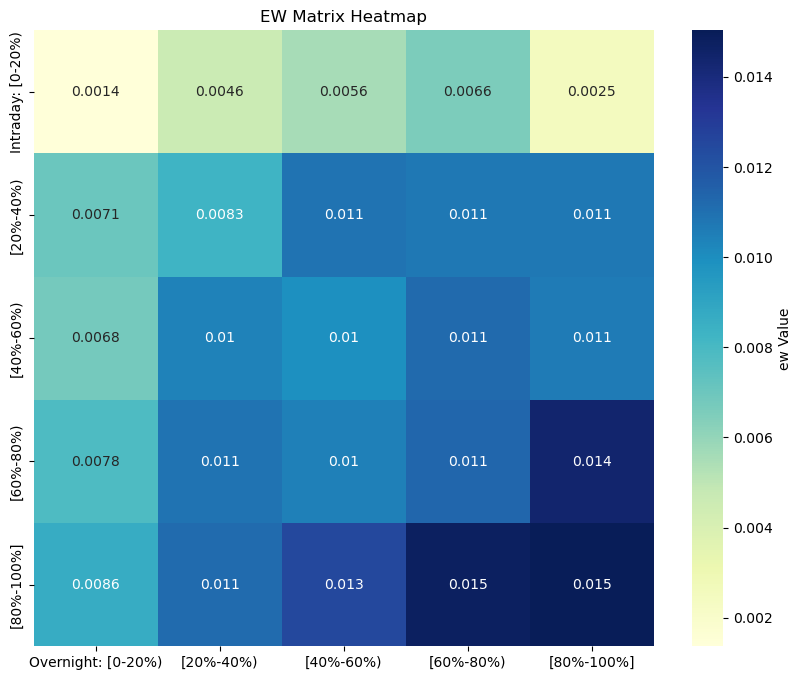

Heatmap for EW_INTRADAY Rerurn


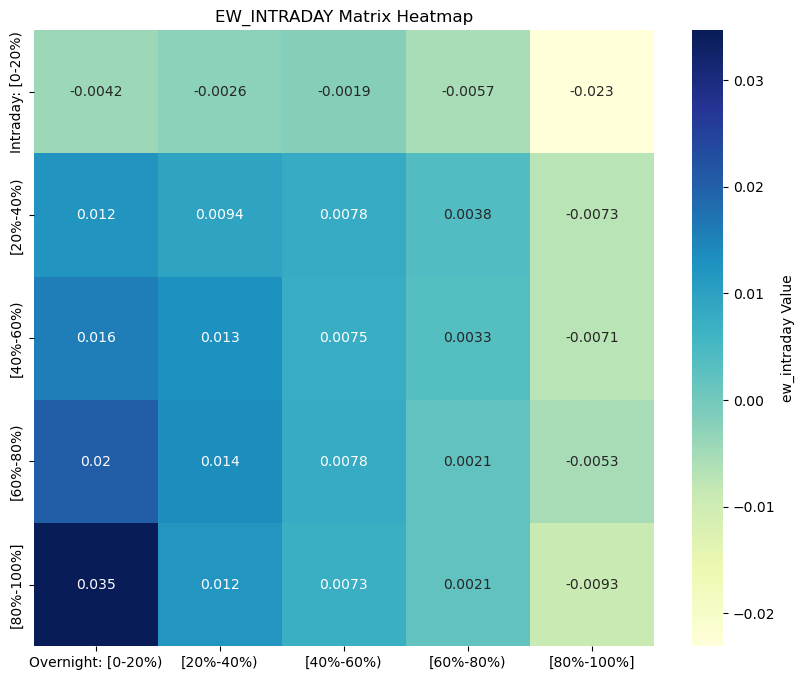

Heatmap for EW_OVERNIGHT Rerurn


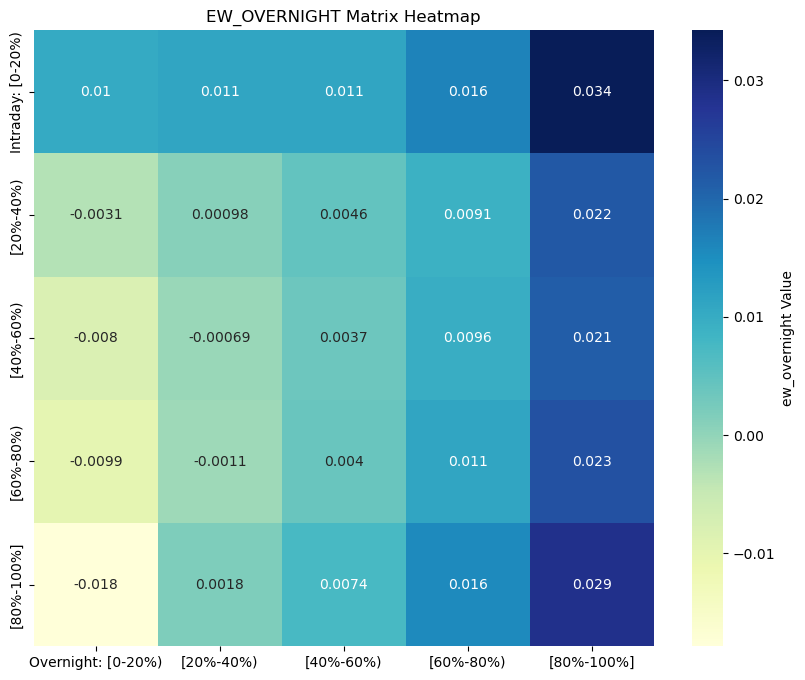

In [61]:
ew_list = ['ew', 'ew_intraday', 'ew_overnight']
for ew in ew_list:
    print(f'Heatmap for {ew.upper()} Rerurn')
    ew_matrix = generate_matrix(data_final_q5, ew)

Heatmap for VW return


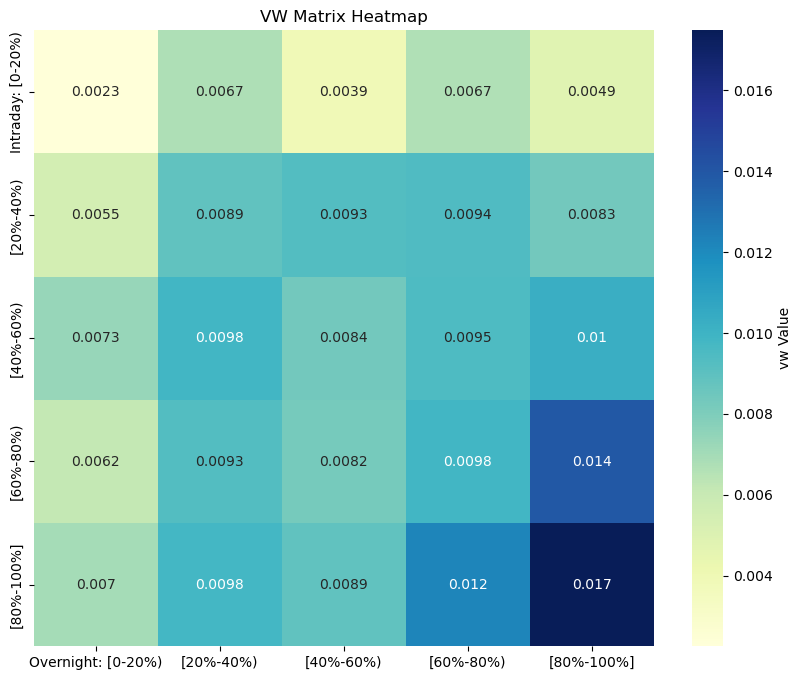

Heatmap for VW_INTRADAY return


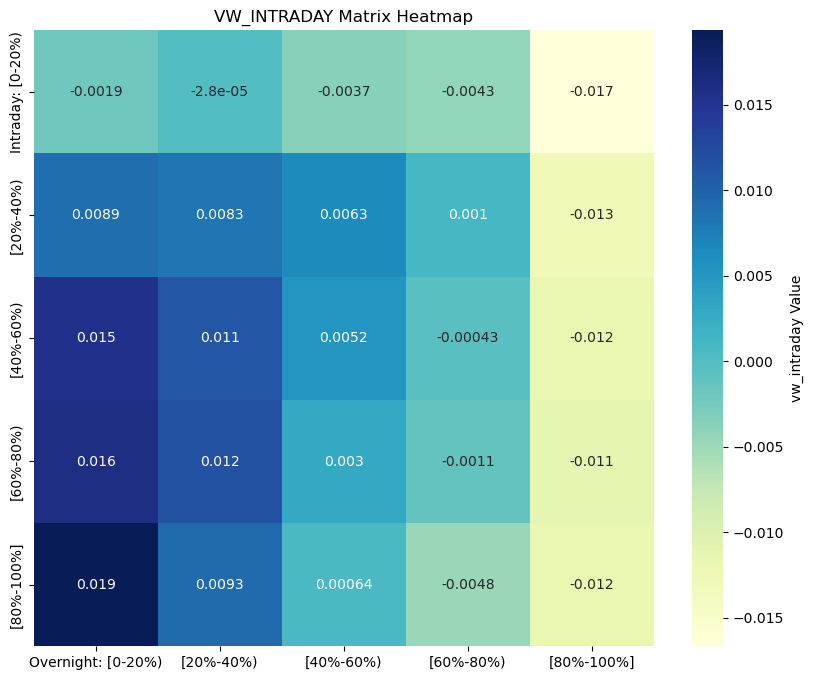

Heatmap for VW_OVERNIGHT return


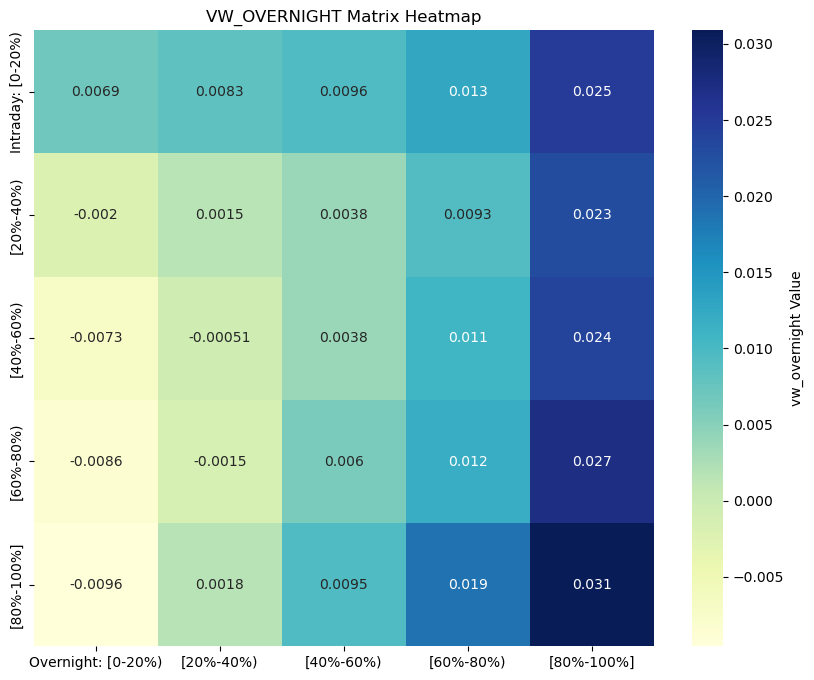

In [62]:
vw_list = ['vw', 'vw_intraday', 'vw_overnight']
for vw in vw_list:
    print(f'Heatmap for {vw.upper()} return')
    vw_matrix = generate_matrix(data_final_q5, vw)

# Q6

1. On average, do you see that intraday momentum explains returns within overnight momentum buckets?
2. On average, do you see that  overnight momentum explains returns within intraday momentum buckets?
3. As both types of momentum increase, are the returns to the strategy increasingly profitable? 
4. What is the most profitable strategy long/short strategy you could construct?

In [64]:
def long_short_strategy(data, value_column):
    long_return = max(data[value_column])
    short_return = min(data[value_column])
    long_short_return = long_return - short_return
    # to get the bin_matrix when long and short
    long_strategy = data[data[value_column] == long_return]['bin_matrix'].values[0]
    short_strategy = data[data[value_column] == short_return]['bin_matrix'].values[0]
    print(f'Long Strategy: {long_strategy}')
    print(f'Short Strategy: {short_strategy}')
    print(f'Long-Short Return: {long_short_return}%')
    return

In [65]:
for ew in ew_list:
    print(f'Long Short Strategy for {ew.upper()} Return')
    ew_long_short = long_short_strategy(data_final_q5, ew)
    print('----' * 10)

Long Short Strategy for EW Return
Long Strategy: 5-5
Short Strategy: 1-1
Long-Short Return: 0.013667249363863595%
----------------------------------------
Long Short Strategy for EW_INTRADAY Return
Long Strategy: 5-1
Short Strategy: 1-5
Long-Short Return: 0.057801207358773324%
----------------------------------------
Long Short Strategy for EW_OVERNIGHT Return
Long Strategy: 1-5
Short Strategy: 5-1
Long-Short Return: 0.05210408228768485%
----------------------------------------


In [66]:
for vw in vw_list:
    print(f'Long Short Strategy for {vw.upper()} Return')
    vw_long_short = long_short_strategy(data_final_q5, vw)
    print('----' * 10)

Long Short Strategy for VW Return
Long Strategy: 5-5
Short Strategy: 1-1
Long-Short Return: 0.015237242030479808%
----------------------------------------
Long Short Strategy for VW_INTRADAY Return
Long Strategy: 5-1
Short Strategy: 1-5
Long-Short Return: 0.03602331060805469%
----------------------------------------
Long Short Strategy for VW_OVERNIGHT Return
Long Strategy: 5-5
Short Strategy: 5-1
Long-Short Return: 0.04046209255728796%
----------------------------------------


In [68]:
# get the most profitable strategy
max_strategy = [0, 0, 0]
def most_profitable_strategy(data, value_column): 
    max_return = max(data[value_column])
    min_return = min(data[value_column])
    long_short_return = max_return - min_return
    if long_short_return > max_strategy[2]:
        max_strategy[0] = data[data[value_column] == max_return]['bin_matrix'].values[0]
        max_strategy[1] = data[data[value_column] == min_return]['bin_matrix'].values[0]
        max_strategy[2] = long_short_return
    return max_strategy


In [67]:
list = ['ew', 'ew_intraday', 'ew_overnight', 'vw', 'vw_intraday', 'vw_overnight']
for value_column in list:
    max_strategy = most_profitable_strategy(data_final_q5, value_column)
max_strategy

['5-1', '1-5', 0.057801207358773324]

# Q 7

In [86]:
def calculate_strategy_returns(df, column, long_bin, short_bin):
    # Group by month
    monthly_returns = []
    dates = df['date'].unique()
    
    for date in dates:
        month_data = df[df['date'] == date]
        # Long 10
        long_ew = month_data[month_data[column] == long_bin]['ew'].values[0] if long_bin in month_data[column].values else 0
        long_vw = month_data[month_data[column] == long_bin]['vw'].values[0] if long_bin in month_data[column].values else 0
        # Short 1
        short_ew = month_data[month_data[column] == short_bin]['ew'].values[0]
        short_vw = month_data[month_data[column] == short_bin]['vw'].values[0]
        # strategy return
        ew_return = long_ew - short_ew
        vw_return = long_vw - short_vw
        monthly_returns.append({'date': date, 'ew': ew_return, 'vw': vw_return})
    
    return pd.DataFrame(monthly_returns)

In [110]:
# Construct long-short strategy for both momentum
df = pd.DataFrame(data_temp)
strategy_df = calculate_strategy_returns(data_temp, 'bin_matrix', '5-5', '1-1')
strategy_df

,date,ew,vw
0,1993-01-29,0.038479,-0.043939
1,1993-02-26,-0.081275,-0.057662
2,1993-03-31,-0.000835,0.026756
3,1993-04-30,0.058810,-0.066486
4,1993-05-28,-0.017690,0.048518
...,...,...,...
352,2022-05-31,0.095680,0.134768
353,2022-06-30,-0.031385,-0.033821
354,2022-07-29,-0.031670,-0.080713
355,2022-08-31,0.023677,-0.001704


In [93]:
# Define function to calculate portfolios and PNL
def calculate_one_m_ret(data, column):
    # Calculate portfolio returns
    portfolios = (
        data
        .groupby(['date', column])
        .agg(
            ew=('ret', 'mean'),
            vw=('ret', lambda x: (x * data.loc[x.index, 'mcap_lag1']).sum() / data.loc[x.index, 'mcap_lag1'].sum())
        )
        .reset_index()
    )

    return {'bins':portfolios}

# Construct long-short strategy for intraday momentum
data_fs_intra = filtered_data[['permno', 'date', 'ret', 'intraday_ret_month', 'overnight_ret_month',
       'mcap_lag1', 'prc_lag1', 'mom_intraday', 'mom', 'mom_overnight',
       'mcap_bin']].copy()
data_fs_intra['bin_mom_intraday'] = new_apply_quantiles(data_fs, 'mom_intraday', 10)
data_fs_intra['bin_mom_overnight'] = new_apply_quantiles(data_fs, 'mom_overnight', 10)

intraday_ret = calculate_one_m_ret(data_fs_intra, 'bin_mom_intraday')
intraday_ret = intraday_ret['bins']
intraday_ret['bin_mom_intraday'] = intraday_ret['bin_mom_intraday'].astype(str)

overnight_ret = calculate_one_m_ret(data_fs_intra, 'bin_mom_overnight')
overnight_ret = overnight_ret['bins']
overnight_ret['bin_mom_overnight'] = overnight_ret['bin_mom_overnight'].astype(str)

In [97]:
# Construct long-short strategy for intraday momentum
intra_strategy_df = calculate_strategy_returns(intraday_ret, 'bin_mom_intraday', '10', '1')
intra_strategy_df

,date,ew,vw
0,1993-01-29,0.014552,-0.024767
1,1993-02-26,0.020675,-0.028136
2,1993-03-31,0.027723,0.046997
3,1993-04-30,0.007117,0.045634
4,1993-05-28,0.001248,0.011355
...,...,...,...
352,2022-05-31,0.046931,0.095632
353,2022-06-30,-0.040391,0.050740
354,2022-07-29,-0.073968,-0.186993
355,2022-08-31,0.018652,-0.036712


In [98]:
# Construct long-short strategy for overnight momentum
overnight_strategy_df = calculate_strategy_returns(overnight_ret, 'bin_mom_overnight', '10', '1')
overnight_strategy_df

,date,ew,vw
0,1993-01-29,-0.016307,-0.019676
1,1993-02-26,-0.059031,-0.041127
2,1993-03-31,-0.002819,0.016071
3,1993-04-30,-0.012983,-0.020477
4,1993-05-28,0.024185,0.048509
...,...,...,...
352,2022-05-31,0.045042,0.054026
353,2022-06-30,-0.013655,-0.035795
354,2022-07-29,0.005550,0.000446
355,2022-08-31,0.016724,0.021984


In [118]:
# Read the Fama French factor file
ff5 = pd.read_parquet('data/ff.five_factor.parquet', engine='pyarrow')
ff5['dt'] = pd.to_datetime(ff5['dt'])
ff5 = ff5.sort_values(by='dt', ascending=True)
ff5 = ff5.rename(columns={'dt': 'date'})
intra_strategy_df['date'] = pd.to_datetime(intra_strategy_df['date'])
overnight_strategy_df['date'] = pd.to_datetime(overnight_strategy_df['date'])
strategy_df['date'] = pd.to_datetime(strategy_df['date'])

one_m_strategy = intra_strategy_df.merge(overnight_strategy_df, on='date', suffixes=('_intraday', '_overnight'))
# merge data
merged_df = strategy_df.merge(one_m_strategy, on='date')
merged_df = merged_df.merge(ff5, on='date')
merged_df

,date,ew,vw,ew_intraday,vw_intraday,ew_overnight,vw_overnight,mkt_rf,smb,hml,rmw,cma,rf
0,1993-01-29,0.038479,-0.043939,0.014552,-0.024767,-0.016307,-0.019676,0.0011,0.0025,0.0011,0.0014,-0.0013,0.00012
1,1993-02-26,-0.081275,-0.057662,0.020675,-0.028136,-0.059031,-0.041127,0.0029,0.0051,-0.0040,0.0018,-0.0014,0.00012
2,1993-03-31,-0.000835,0.026756,0.027723,0.046997,-0.002819,0.016071,0.0015,0.0061,-0.0032,0.0003,-0.0007,0.00011
3,1993-04-30,0.058810,-0.066486,0.007117,0.045634,-0.012983,-0.020477,0.0038,0.0033,-0.0005,-0.0012,-0.0003,0.00011
4,1993-05-28,-0.017690,0.048518,0.001248,0.011355,0.024185,0.048509,-0.0040,0.0016,0.0006,-0.0001,-0.0034,0.00011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2022-05-31,0.095680,0.134768,0.046931,0.095632,0.045042,0.054026,-0.0071,-0.0037,0.0040,0.0078,-0.0024,0.00001
353,2022-06-30,-0.031385,-0.033821,-0.040391,0.050740,-0.013655,-0.035795,-0.0096,0.0051,-0.0015,0.0090,-0.0016,0.00003
354,2022-07-29,-0.031670,-0.080713,-0.073968,-0.186993,0.005550,0.000446,0.0145,-0.0088,0.0045,0.0048,-0.0117,0.00004
355,2022-08-31,0.023677,-0.001704,0.018652,-0.036712,0.016724,0.021984,-0.0074,0.0023,-0.0045,-0.0062,-0.0013,0.00008


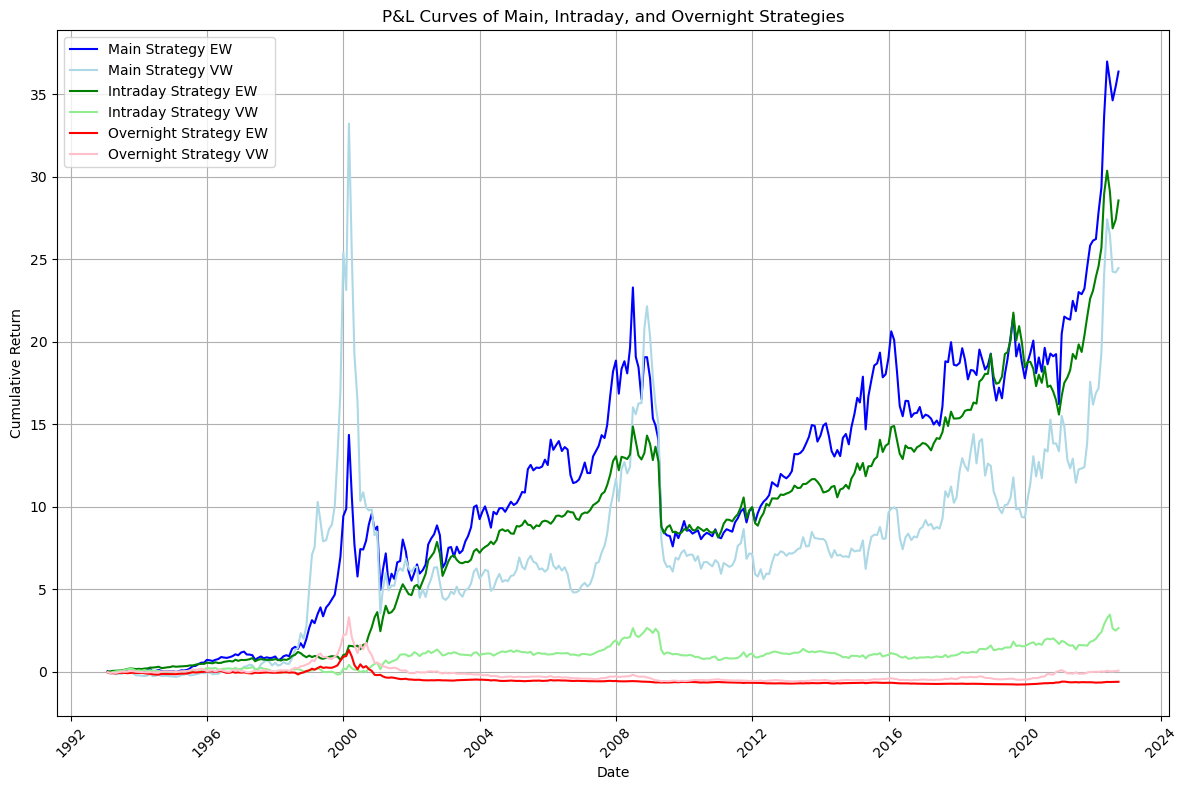


Results Table:
      Metric                 Strategy   Value
Sharpe Ratio         Main Strategy EW  0.5711
Sharpe Ratio         Main Strategy VW  0.4737
Sharpe Ratio              Intraday EW  0.7302
Sharpe Ratio              Intraday VW  0.3035
Sharpe Ratio             Overnight EW -0.1177
Sharpe Ratio             Overnight VW  0.1133
       Alpha        EW vs Intraday EW  0.0031
       Alpha        VW vs Intraday VW  0.0089
       Alpha       EW vs Overnight EW  0.0150
       Alpha       VW vs Overnight VW  0.0135
       Alpha  EW vs Intraday EW + FF5  0.0024
       Alpha  VW vs Intraday VW + FF5  0.0078
       Alpha EW vs Overnight EW + FF5  0.0127
       Alpha VW vs Overnight VW + FF5  0.0100
      t-stat        EW vs Intraday EW  0.8621
      t-stat        VW vs Intraday VW  1.9711
      t-stat       EW vs Overnight EW  3.9481
      t-stat       VW vs Overnight VW  2.5782
      t-stat  EW vs Intraday EW + FF5  0.6639
      t-stat  VW vs Intraday VW + FF5  1.6876
      t-stat EW vs

In [124]:
# Calculate sharpe ratio
def calculate_sharpe_ratio(returns, rf):
    '''
        Calculate Sharpe ratio
    '''
    excess_returns = returns - rf
    mean_excess = excess_returns.mean()
    std_excess = excess_returns.std()
    sharpe = mean_excess / std_excess * np.sqrt(12)  # 年化
    return sharpe


sharpe_results = {
    'Main Strategy EW': calculate_sharpe_ratio(merged_df['ew'], merged_df['rf']),
    'Main Strategy VW': calculate_sharpe_ratio(merged_df['vw'], merged_df['rf']),
    'Intraday EW': calculate_sharpe_ratio(merged_df['ew_intraday'], merged_df['rf']),
    'Intraday VW': calculate_sharpe_ratio(merged_df['vw_intraday'], merged_df['rf']),
    'Overnight EW': calculate_sharpe_ratio(merged_df['ew_overnight'], merged_df['rf']),
    'Overnight VW': calculate_sharpe_ratio(merged_df['vw_overnight'], merged_df['rf'])
}

# 4. 计算所有策略的累计收益并绘制 P&L 曲线
merged_df['ew_cumulative'] = (1 + merged_df['ew']).cumprod() - 1
merged_df['vw_cumulative'] = (1 + merged_df['vw']).cumprod() - 1
merged_df['ew_intraday_cumulative'] = (1 + merged_df['ew_intraday']).cumprod() - 1
merged_df['vw_intraday_cumulative'] = (1 + merged_df['vw_intraday']).cumprod() - 1
merged_df['ew_overnight_cumulative'] = (1 + merged_df['ew_overnight']).cumprod() - 1
merged_df['vw_overnight_cumulative'] = (1 + merged_df['vw_overnight']).cumprod() - 1

plt.figure(figsize=(12, 8))
plt.plot(merged_df['date'], merged_df['ew_cumulative'], label='Main Strategy EW', color='blue')
plt.plot(merged_df['date'], merged_df['vw_cumulative'], label='Main Strategy VW', color='lightblue')
plt.plot(merged_df['date'], merged_df['ew_intraday_cumulative'], label='Intraday Strategy EW', color='green')
plt.plot(merged_df['date'], merged_df['vw_intraday_cumulative'], label='Intraday Strategy VW', color='lightgreen')
plt.plot(merged_df['date'], merged_df['ew_overnight_cumulative'], label='Overnight Strategy EW', color='red')
plt.plot(merged_df['date'], merged_df['vw_overnight_cumulative'], label='Overnight Strategy VW', color='pink')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('P&L Curves of Main, Intraday, and Overnight Strategies')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# 5. Alpha 分析
def calculate_alpha(return_series, factors):
    X = sm.add_constant(factors)
    model = sm.OLS(return_series, X).fit()
    alpha = model.params['const']
    t_stat = model.tvalues['const']
    return alpha, t_stat

alpha_results = {}

# Alpha vs Intraday Momentum
alpha_results['EW vs Intraday EW'] = calculate_alpha(merged_df['ew'], merged_df['ew_intraday'])
alpha_results['VW vs Intraday VW'] = calculate_alpha(merged_df['vw'], merged_df['vw_intraday'])

# Alpha vs Overnight Momentum
alpha_results['EW vs Overnight EW'] = calculate_alpha(merged_df['ew'], merged_df['ew_overnight'])
alpha_results['VW vs Overnight VW'] = calculate_alpha(merged_df['vw'], merged_df['vw_overnight'])

# Alpha vs Intraday + FF5
ff5_factors_intra = merged_df[['ew_intraday', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma']]
alpha_results['EW vs Intraday EW + FF5'] = calculate_alpha(merged_df['ew'], ff5_factors_intra)
ff5_factors_intra_vw = merged_df[['vw_intraday', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma']]
alpha_results['VW vs Intraday VW + FF5'] = calculate_alpha(merged_df['vw'], ff5_factors_intra_vw)

# Alpha vs Overnight + FF5
ff5_factors_over = merged_df[['ew_overnight', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma']]
alpha_results['EW vs Overnight EW + FF5'] = calculate_alpha(merged_df['ew'], ff5_factors_over)
ff5_factors_over_vw = merged_df[['vw_overnight', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma']]
alpha_results['VW vs Overnight VW + FF5'] = calculate_alpha(merged_df['vw'], ff5_factors_over_vw)

# 6. 创建结果表格
results_df = pd.DataFrame({
    'Metric': ['Sharpe Ratio'] * 6 + ['Alpha'] * 8 + ['t-stat'] * 8,
    'Strategy': [
        'Main Strategy EW', 'Main Strategy VW', 'Intraday EW', 'Intraday VW', 'Overnight EW', 'Overnight VW',
        'EW vs Intraday EW', 'VW vs Intraday VW', 'EW vs Overnight EW', 'VW vs Overnight VW',
        'EW vs Intraday EW + FF5', 'VW vs Intraday VW + FF5', 'EW vs Overnight EW + FF5', 'VW vs Overnight VW + FF5',
        'EW vs Intraday EW', 'VW vs Intraday VW', 'EW vs Overnight EW', 'VW vs Overnight VW',
        'EW vs Intraday EW + FF5', 'VW vs Intraday VW + FF5', 'EW vs Overnight EW + FF5', 'VW vs Overnight VW + FF5'
    ],
    'Value': [
        sharpe_results['Main Strategy EW'], sharpe_results['Main Strategy VW'],
        sharpe_results['Intraday EW'], sharpe_results['Intraday VW'],
        sharpe_results['Overnight EW'], sharpe_results['Overnight VW'],
        alpha_results['EW vs Intraday EW'][0], alpha_results['VW vs Intraday VW'][0],
        alpha_results['EW vs Overnight EW'][0], alpha_results['VW vs Overnight VW'][0],
        alpha_results['EW vs Intraday EW + FF5'][0], alpha_results['VW vs Intraday VW + FF5'][0],
        alpha_results['EW vs Overnight EW + FF5'][0], alpha_results['VW vs Overnight VW + FF5'][0],
        alpha_results['EW vs Intraday EW'][1], alpha_results['VW vs Intraday VW'][1],
        alpha_results['EW vs Overnight EW'][1], alpha_results['VW vs Overnight VW'][1],
        alpha_results['EW vs Intraday EW + FF5'][1], alpha_results['VW vs Intraday VW + FF5'][1],
        alpha_results['EW vs Overnight EW + FF5'][1], alpha_results['VW vs Overnight VW + FF5'][1]
    ]
})

# 格式化表格
results_df['Value'] = results_df['Value'].apply(lambda x: f"{x:.4f}")
print("\nResults Table:")
print(results_df.to_string(index=False))

# 7. 策略表现是否良好
ew_mean = merged_df['ew'].mean()
vw_mean = merged_df['vw'].mean()
print(f"\nEW Strategy Mean Return: {ew_mean:.4f}")
print(f"VW Strategy Mean Return: {vw_mean:.4f}")
print("Strategy performs well if mean returns are positive and Sharpe ratios are competitive.")

# End